<a href="https://colab.research.google.com/github/jeric250/Data-Science-Projects/blob/main/Classification_Multinomial_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Multinomial Naive Bayes on DonorsChoose Dataset</h3>

The dataset contains classroom project proposals in need of funding received by [DonorsChoose](https://www.donorschoose.org/), a NGO based in the US. 

The goal is to build a model to predict whether a project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. The NGO can use this information to identify projects most likely to need further review before approval.

The dataset contains a mix of categorical, numerical and text data. For text data, both Bag of Words (BoW) and TF-IDF vectorizers are used to convert text into vectors, which are then seperately used by the model for performance comparison.

This is partly inspired by the course work from the Applied Roots's [Applied Machine Learning course](https://www.appliedaicourse.com/course/11/Applied-Machine-learning-course).

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB

import re

import pickle
from tqdm import tqdm
import os

## 1. Load and Split Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/preprocessed_data.csv', nrows=80000) # obtain 80,000 data points

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   school_state                                  80000 non-null  object 
 1   teacher_prefix                                80000 non-null  object 
 2   project_grade_category                        80000 non-null  object 
 3   teacher_number_of_previously_posted_projects  80000 non-null  int64  
 4   project_is_approved                           80000 non-null  int64  
 5   clean_categories                              80000 non-null  object 
 6   clean_subcategories                           80000 non-null  object 
 7   essay                                         80000 non-null  object 
 8   price                                         80000 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 5.5+ MB


In [ ]:
print("No. of Data Points:", data.shape[0])
print("No. of Features:", data.shape[1])
print("\nUnique values:\n", data.nunique())

No. of Data Points: 80000
No. of Features: 9

Unique values:
 school_state                                       51
teacher_prefix                                      5
project_grade_category                              4
teacher_number_of_previously_posted_projects      335
project_is_approved                                 2
clean_categories                                   51
clean_subcategories                               392
essay                                           79476
price                                           42636
dtype: int64


In [ ]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
data.groupby('project_is_approved').size() # imbalanced data (15%:85%)

project_is_approved
0    12286
1    67714
dtype: int64

In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
y.shape

(80000,)

In [ ]:
# train test split (no validation set as intend to do Randomized Search CV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

print(X_train.shape, y_train.shape)
# print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(53600, 8) (53600,)
(26400, 8) (26400,)


## 2a. Perform BoW Vectorization, Categorical Encoding, Numerical Scaling

In [ ]:
# perform BoW vectorization of text data (essay column)
bow_vectorizer = CountVectorizer(min_df=10, ngram_range=(1,4), max_features=7000)
bow_vectorizer.fit(X_train['essay'].values) # fit only on train data

# use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = bow_vectorizer.transform(X_train['essay'].values)
# X_cv_essay_bow = bow_vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = bow_vectorizer.transform(X_test['essay'].values)

print(X_train_essay_bow.shape, y_train.shape)
# print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

(53600, 7000) (53600,)
(26400, 7000) (26400,)


In [ ]:
# identify categorical features for encoding
categorical_col = list(X.select_dtypes(include=['object','category']).drop(['essay'], axis=1).columns)
categorical_col

['school_state',
 'teacher_prefix',
 'project_grade_category',
 'clean_categories',
 'clean_subcategories']

In [ ]:
# use one hot encoder to encode categorical features
# identify all nominal categories from train data and encode test data according to the categories identified in training. If there are new categories in the test data, encode as 0
# reference: https://stackoverflow.com/questions/57946006/one-hot-encoding-train-with-values-not-present-on-test
# reference: https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset
enc = OneHotEncoder(handle_unknown = 'ignore') # 'ignore' tells the encoder to ignore new categories by encoding them with 0
enc.fit(X_train[categorical_col].values)

# use the fitted encoder to encode categorical features
X_train_ohe = enc.transform(X_train[categorical_col].values)
X_test_ohe = enc.transform(X_test[categorical_col].values)

print(X_train_ohe.shape, y_train.shape)
print(X_test_ohe.shape, y_test.shape)

(53600, 487) (53600,)
(26400, 487) (26400,)


In [ ]:
# identify numerical features for scaling
numerical_col = list(X.select_dtypes(include=['int','float']).columns)
numerical_col

['teacher_number_of_previously_posted_projects', 'price']

In [ ]:
normalizer = Normalizer()
normalizer.fit(X_train[numerical_col].values)

X_train_norm = normalizer.transform(X_train[numerical_col].values)
X_test_norm = normalizer.transform(X_test[numerical_col].values)

print(X_train_norm.shape, y_train.shape)
print(X_test_norm.shape, y_test.shape)

(53600, 2) (53600,)
(26400, 2) (26400,)


In [ ]:
print(X_train_norm.min())
print(X_train_norm.max())
print(X_test_norm.min())
print(X_test_norm.max())

0.0
1.0
0.0
1.0


In [ ]:
# merge matrices for BoW
# reference: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_train_bow = hstack((X_train_essay_bow, X_train_ohe, X_train_norm)).tocsr()
X_test_bow = hstack((X_test_essay_bow, X_test_ohe, X_test_norm)).tocsr()

print("Final data matrix (Bow)")
print(X_train_bow.shape, y_train.shape) # why previously 6491/6489 cols? diff comes from one hot encoding of cat features, possibly due to random 80k rows when reading csv file
print(X_test_bow.shape, y_test.shape)

Final data matrix (Bow)
(53600, 7489) (53600,)
(26400, 7489) (26400,)


## 2b. Perform hyperparameter tuning (BoW)

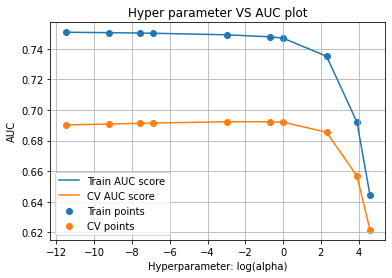

In [ ]:
# BoW hyperparameter tuning
multi_nb = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = RandomizedSearchCV(multi_nb, parameters, cv=3, scoring='roc_auc', return_train_score=True, random_state=42)
clf.fit(X_train_bow, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV
results = results.sort_values(['param_alpha'])
train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(np.log(alpha.astype(float)), train_auc, label='Train AUC score') # reference: https://stackoverflow.com/questions/59297543/why-do-i-get-the-loop-of-ufunc-does-not-support-argument-0-of-type-int-error-f
plt.plot(np.log(alpha.astype(float)), cv_auc, label='CV AUC score')

plt.scatter(np.log(alpha.astype(float)), train_auc, label='Train points')
plt.scatter(np.log(alpha.astype(float)), cv_auc, label='CV points')

plt.legend()
plt.xlabel("Hyperparameter: log(alpha)")
plt.ylabel("AUC")
plt.title("Hyper parameter VS AUC plot")
plt.grid()
plt.show()

In [ ]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.090715,0.025952,0.028722,0.006430,0.00001,{'alpha': 1e-05},0.684022,0.684517,0.702049,0.690196,0.008384,7,0.749742,0.752633,0.750062,0.750812,0.001294
6,0.067281,0.000448,0.025342,0.000837,0.0001,{'alpha': 0.0001},0.684619,0.685053,0.702724,0.690799,0.008434,6,0.749478,0.752357,0.749789,0.750542,0.001290
7,0.069077,0.001685,0.025572,0.000841,0.0005,{'alpha': 0.0005},0.685074,0.685446,0.703185,0.691235,0.008451,5,0.749236,0.752098,0.749534,0.750289,0.001285
9,0.068891,0.000571,0.023771,0.000126,0.001,{'alpha': 0.001},0.685263,0.685620,0.703373,0.691419,0.008454,4,0.749117,0.751967,0.749404,0.750163,0.001281
4,0.120707,0.016000,0.039885,0.003614,0.05,{'alpha': 0.05},0.686200,0.686453,0.704204,0.692285,0.008428,1,0.748178,0.750915,0.748348,0.749147,0.001252
5,0.098909,0.003849,0.040582,0.008820,0.5,{'alpha': 0.5},0.686296,0.686361,0.704190,0.692283,0.008420,2,0.746949,0.749553,0.746948,0.747817,0.001228
0,0.068876,0.000183,0.025218,0.001580,1,{'alpha': 1},0.686066,0.685957,0.703927,0.691983,0.008446,3,0.746102,0.748669,0.746028,0.746933,0.001228
1,0.068465,0.000779,0.024521,0.000135,10,{'alpha': 10},0.680390,0.678242,0.697616,0.685416,0.008671,8,0.734648,0.737016,0.733752,0.735139,0.001377
3,0.102939,0.005782,0.042762,0.006029,50,{'alpha': 50},0.654534,0.648917,0.666738,0.656729,0.007439,9,0.691763,0.694865,0.689533,0.692053,0.002187
8,0.067001,0.000833,0.023540,0.000168,100,{'alpha': 100},0.618506,0.615575,0.630553,0.621545,0.006481,10,0.644679,0.646814,0.640776,0.644090,0.002500


## 2c. Compute Performance Metrics (BoW)

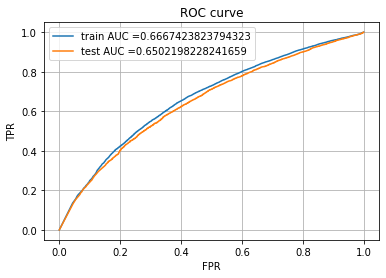

In [ ]:
# compute and plot ROC
best_alpha_bow = 100
clf = MultinomialNB(alpha=best_alpha_bow)
clf.fit(X_train_bow, y_train)

y_train_pred = clf.predict_proba(X_train_bow)[:,1] # include proba for positive class only
y_test_pred = clf.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) 
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [ ]:
auc_bow = auc(test_fpr, test_tpr) # AUC score
auc_bow

0.6502198228241659

In [ ]:
np.exp(clf.class_log_prior_) # computed class prior

array([0.15358209, 0.84641791])

In [ ]:
# define function to obtain best threshold for max(tpr*(1-fpr)) + predict class using best threshold
# reference: https://colab.research.google.com/drive/1QE7c9oVfSwQcoLv8pxIqa6b9meiuqNgX

def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be max if fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr) is", max(tpr*(1-fpr)), "with threshold of", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm_train_bow = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test_bow = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

print("\nTrain confusion matrix:\n")
print(cm_train_bow)
print("\nTest confusion matrix:\n")
print(cm_test_bow)

The maximum value of tpr*(1-fpr) is 0.39400783425948155 with threshold of 1.0

Train confusion matrix:

[[ 5060  3172]
 [16287 29081]]

Test confusion matrix:

[[ 2352  1702]
 [ 8031 14315]]


In [ ]:
tn, fp, fn, tp = cm_test_bow.ravel()
(tn, fp, fn, tp)

(2352, 1702, 8031, 14315)

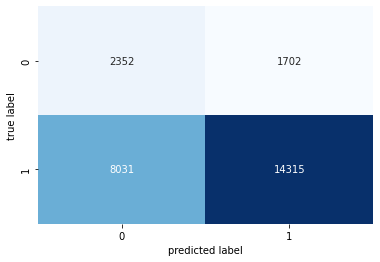

In [ ]:
# reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
sns.heatmap(cm_test_bow, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [ ]:
print('The TPR (sensitivity/recall) is {:.2f}, while the FNR is {:.2f}'.format(tp/(fn+tp), fn/(fn+tp)))
print('The TNR (specificity) is {:.2f}, while the FPR is {:.2f}'.format(tn/(tn+fp), fp/(tn+fp)))
print('Precision is {:.2f}'.format(tp/(tp+fp)))

The TPR (sensitivity/recall) is 0.64, while the FNR is 0.36
The TNR (specificity) is 0.58, while the FPR is 0.42
Precision is 0.89


>While the AUC score of 0.65 is greater than 0.5, it is not very high. As the dataset is imbalanced in favour of the positive class, identifying true negatives is relatively important, lending more importance to specificity (which is not very high at 0.58). Thus, the classifier can possibly be tuned further (or subjected to better feature engineering) for better performance.

In [ ]:
# prepare list of features names
features_bow = []
features_bow.extend(bow_vectorizer.get_feature_names_out())
features_bow.extend(enc.get_feature_names_out())
features_bow.append('teacher_number_of_previously_posted_projects')
features_bow.append('price')

len(features_bow)
# X_train_bow = hstack((X_train_essay_bow, X_train_ohe, X_train_norm)).tocsr()

7489

In [ ]:
# obtain top 20 features for positive class based on prob scores
# feature_log_prob_ returns log prob for each class
# reference: https://stackoverflow.com/questions/56338847/how-to-give-column-names-after-one-hot-encoding-with-sklearn
# reference: https://stackoverflow.com/questions/52374104/typeerror-unsupported-format-string-passed-to-list-format
# reference: https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
# reference: https://stackoverflow.com/questions/54988116/why-am-i-getting-almost-same-top-10-features-using-multinomial-naive-bayes-class
sorted_idx = np.argsort(clf.feature_log_prob_[1])[::-1][:20] # [::-1] reverses the array returned by argsort() to desc order and [:n] gives that top n elements

for p,q in zip(np.array(features_bow)[sorted_idx], clf.feature_log_prob_[1][sorted_idx]): # need to wrap features_bow (which is a list) as an array
  print('{:45}:{}'.format(p,q))

love                                         :-5.667311510360365
use                                          :-5.5548139893873945
need                                         :-5.506206190496119
work                                         :-5.491952201409097
reading                                      :-5.47873468868146
we                                           :-5.438223008463405
nannan                                       :-5.395876410572454
many                                         :-5.365700270820415
price                                        :-5.360124289726725
help                                         :-5.214111108448558
learn                                        :-5.188944573554069
my students                                  :-5.1788084907746
they                                         :-5.155054404766494
not                                          :-5.140905415619127
the                                          :-5.095707870828489
classroom                  

In [ ]:
# use np.exp() to obtain normal probability
# reference: https://stackoverflow.com/questions/48465737/how-to-convert-log-probability-into-simple-probability-between-0-and-1-values-us
sorted_idx = np.argsort(np.exp(clf.feature_log_prob_[1]))[::-1][:20]

for p,q in zip(np.array(features_bow)[sorted_idx], np.exp(clf.feature_log_prob_[1])[sorted_idx]):
  print('{:45}:{}'.format(p,q))

students                                     :0.03528237336301718
school                                       :0.01114784500738944
my                                           :0.008196201004322298
learning                                     :0.007896306439209464
classroom                                    :0.007668581278968522
the                                          :0.006122970828002388
not                                          :0.0058523884698536465
they                                         :0.005770166142015723
my students                                  :0.005634716232578742
learn                                        :0.005577890762760256
help                                         :0.00543926624607083
price                                        :0.00470032186955595
many                                         :0.004674185898235341
nannan                                       :0.004535243920820679
we                                           :0.00434720135123510

In [ ]:
# obtain top 20 features for negative class based on prob scores
sorted_idx = np.argsort(clf.feature_log_prob_[0])[::-1][:20]

for p,q in zip(np.array(features_bow)[sorted_idx], clf.feature_log_prob_[0][sorted_idx]):
  print('{:45}:{}'.format(p,q))

students                                     :-3.6775571770632176
school                                       :-4.775482670659821
learning                                     :-5.073516527655084
my                                           :-5.1436535203911316
classroom                                    :-5.2191655622270225
not                                          :-5.424263051099025
learn                                        :-5.431259277354647
they                                         :-5.475465944718639
the                                          :-5.4872333034383765
help                                         :-5.487448542354404
my students                                  :-5.519825864611082
price                                        :-5.603634737624848
nannan                                       :-5.653690831486767
many                                         :-5.673328246198455
we                                           :-5.769585082625182
need                 

## 3a. Perform TFIDF Vectorization, Categorical Encoding, Numerical Scaling

In [ ]:
# perform TF-IDF vectorization of text data (essay column)
tfidf_vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=7000)
tfidf_vectorizer.fit(X_train['essay'].values) # fit only on train data

# use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = tfidf_vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf_vectorizer.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(53600, 7000) (53600,)
(26400, 7000) (26400,)


In [ ]:
# merge matrices for TF-IDF (reuse existing matrices for categorical and numerical features)
X_train_tfidf = hstack((X_train_essay_tfidf, X_train_ohe, X_train_norm)).tocsr()
X_test_tfidf = hstack((X_test_essay_tfidf, X_test_ohe, X_test_norm)).tocsr()

print("Final data matrix (TF-IDF)")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

Final data matrix (TF-IDF)
(53600, 7489) (53600,)
(26400, 7489) (26400,)


## 3b. Perform hyperparameter tuning (TFIDF)

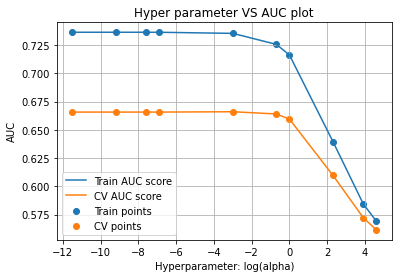

In [ ]:
# TF-IDF hyperparameter tuning
multi_nb = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = RandomizedSearchCV(multi_nb, parameters, cv=3, scoring='roc_auc', return_train_score=True, random_state=42)
clf.fit(X_train_tfidf, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV
results = results.sort_values(['param_alpha'])

train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(np.log(alpha.astype(float)), train_auc, label='Train AUC score') # reference: https://stackoverflow.com/questions/59297543/why-do-i-get-the-loop-of-ufunc-does-not-support-argument-0-of-type-int-error-f
plt.plot(np.log(alpha.astype(float)), cv_auc, label='CV AUC score')

plt.scatter(np.log(alpha.astype(float)), train_auc, label='Train points')
plt.scatter(np.log(alpha.astype(float)), cv_auc, label='CV points')

plt.legend()
plt.xlabel("Hyperparameter: log(alpha)")
plt.ylabel("AUC")
plt.title("Hyper parameter VS AUC plot")
plt.grid()
plt.show()

## 3c. Compute Performance Metrics (TFIDF)

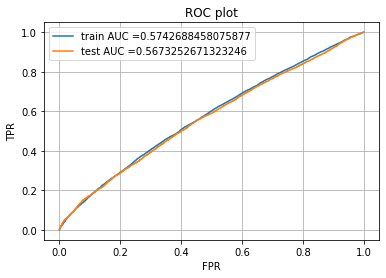

In [ ]:
# compute and plot ROC
best_alpha_tfidf = 100
clf = MultinomialNB(alpha=best_alpha_tfidf)
clf.fit(X_train_tfidf, y_train)

y_train_pred = clf.predict_proba(X_train_tfidf)[:,1]
y_test_pred = clf.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) 
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC plot")
plt.grid()
plt.show()

In [ ]:
# computed class prior
np.exp(clf.class_log_prior_)

array([0.15358209, 0.84641791])

In [ ]:
auc_tfidf = auc(test_fpr, test_tpr) # AUC score
auc_tfidf

0.5673252671323246

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm_train_tfidf = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test_tfidf = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

print("\nTrain confusion matrix:\n")
print(cm_train_tfidf)
print("\nTest confusion matrix:\n")
print(cm_test_tfidf)

The maximum value of tpr*(1-fpr) is 0.3059946955329478 with threshold of 1.0

Train confusion matrix:

[[ 4844  3388]
 [21776 23592]]

Test confusion matrix:

[[ 2370  1684]
 [10897 11449]]


In [ ]:
tn, fp, fn, tp = cm_test_tfidf.ravel()
(tn, fp, fn, tp)

(2370, 1684, 10897, 11449)

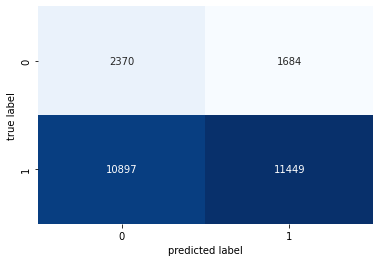

In [ ]:
sns.heatmap(cm_test_tfidf, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [ ]:
print('The TPR (sensitivity/recall) is {:.2f}, while the FNR is {:.2f}'.format(tp/(fn+tp), fn/(fn+tp)))
print('The TNR (specificity) is {:.2f}, while the FPR is {:.2f}'.format(tn/(tn+fp), fp/(tn+fp)))
print('Precision is {:.2f}'.format(tp/(tp+fp)))

The TPR (sensitivity/recall) is 0.51, while the FNR is 0.49
The TNR (specificity) is 0.58, while the FPR is 0.42
Precision is 0.87


>While the AUC score of 0.57 is greater than 0.5, it is not very high. As the dataset is imbalanced in favour of the positive class, identifying true negatives is relatively important, lending more importance to specificity (which is not very high at 0.58). Thus, the classifier can possibly be tuned further (or subjected to better feature engineering) for better performance.

In [ ]:
# prepare list of features names
features_tfidf = []
features_tfidf.extend(tfidf_vectorizer.get_feature_names_out())
features_tfidf.extend(enc.get_feature_names_out())
features_tfidf.append('teacher_number_of_previously_posted_projects')
features_tfidf.append('price')

len(features_tfidf)

7489

In [ ]:
# obtain top 20 features for positive class based on prob scores
# feature_log_prob_ returns log prob for each class
sorted_idx = np.argsort(clf.feature_log_prob_[1])[::-1][:20] # [::-1] reverses the array returned by argsort() to desc order and [:n] gives that top n elements

for p,q in zip(np.array(features_tfidf)[sorted_idx], clf.feature_log_prob_[1][sorted_idx]): # need to wrap features_bow (which is a list) as an array
  print('{:45}:{}'.format(p,q))

price                                        :-3.5223951568406964
x1_mrs                                       :-4.130306996812369
x2_grades_prek_2                             :-4.400216712761626
x1_ms                                        :-4.532820088491508
x2_grades_3_5                                :-4.558247310090291
x3_literacy_language                         :-5.001624758339693
x2_grades_6_8                                :-5.36272833855169
x3_math_science                              :-5.407534673334871
x0_ca                                        :-5.4118447045294715
x3_literacy_language math_science            :-5.468372501920964
students                                     :-5.636605759169363
x3_health_sports                             :-5.670848520947397
x2_grades_9_12                               :-5.814855276093468
x1_mr                                        :-5.826737491893196
x4_literacy                                  :-5.89028417308651
x4_literacy mathematics  

In [ ]:
# use np.exp() to obtain normal probability
sorted_idx = np.argsort(np.exp(clf.feature_log_prob_[1]))[::-1][:20]

for p,q in zip(np.array(features_tfidf)[sorted_idx], np.exp(clf.feature_log_prob_[1])[sorted_idx]):
  print('{:45}:{}'.format(p,q))

price                                        :0.02952862471319333
x1_mrs                                       :0.01607794218786052
x2_grades_prek_2                             :0.012274679535110881
x1_ms                                        :0.010750316440764626
x2_grades_3_5                                :0.010480411767278111
x3_literacy_language                         :0.0067270083522414925
x2_grades_6_8                                :0.004688097924696816
x3_math_science                              :0.004482677865319142
x0_ca                                        :0.004463398960070109
x3_literacy_language math_science            :0.004218091510522019
students                                     :0.0035649481864758557
x3_health_sports                             :0.0034449409310520255
x2_grades_9_12                               :0.0029829119949113182
x1_mr                                        :0.002947678133594108
x4_literacy                                  :0.002766190508

In [ ]:
# obtain top 20 features for negative class based on prob scores
sorted_idx = np.argsort(clf.feature_log_prob_[0])[::-1][:20] # [::-1] reverses the array returned by argsort() to desc order and [:n] gives that top n elements

for p,q in zip(np.array(features_tfidf)[sorted_idx], clf.feature_log_prob_[0][sorted_idx]): # need to wrap features_bow (which is a list) as an array
  print('{:45}:{}'.format(p,q))

price                                        :-4.6718711434710745
x1_mrs                                       :-5.344185361908
x2_grades_prek_2                             :-5.553629666145618
x1_ms                                        :-5.637011275084669
x2_grades_3_5                                :-5.75797295295968
x3_literacy_language                         :-6.2418256206304035
x3_math_science                              :-6.298608126734187
x2_grades_6_8                                :-6.413167581427323
x0_ca                                        :-6.589987061067294
x3_literacy_language math_science            :-6.731190370931776
students                                     :-6.750494547764777
x2_grades_9_12                               :-6.820358315502957
x3_health_sports                             :-6.8423602506964425
x1_mr                                        :-6.875750536246975
x0_tx                                        :-6.978315886932471
x4_literacy               

## 4. Summary

In [ ]:
%pip install prettytable

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

In [ ]:
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
x.add_rows(
    [
        ["BoW", 'Multinomial Naive Bayes', best_alpha_bow, auc_bow],
        ["TFIDF", 'Multinomial Naive Bayes', best_alpha_tfidf, auc_tfidf]
    ]
)
print(x)

+------------+-------------------------+----------------+--------------------+
| Vectorizer |          Model          | Hyperparameter |        AUC         |
+------------+-------------------------+----------------+--------------------+
|    BoW     | Multinomial Naive Bayes |      100       | 0.6502198228241659 |
|   TFIDF    | Multinomial Naive Bayes |      100       | 0.5673252671323246 |
+------------+-------------------------+----------------+--------------------+
